In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Exploracion con Lasso y Ridge: Wallmart Sales
## Cargar el dataset

In [113]:
dataset_path: Path = Path.cwd() / 'wallmart' / 'Walmart_Sales.csv'
assert dataset_path.exists(), 'Dataset not found'
dataset = pd.read_csv(dataset_path)

## Analisis de dataset

In [114]:
print(dataset.info())
dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [115]:
dataset.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


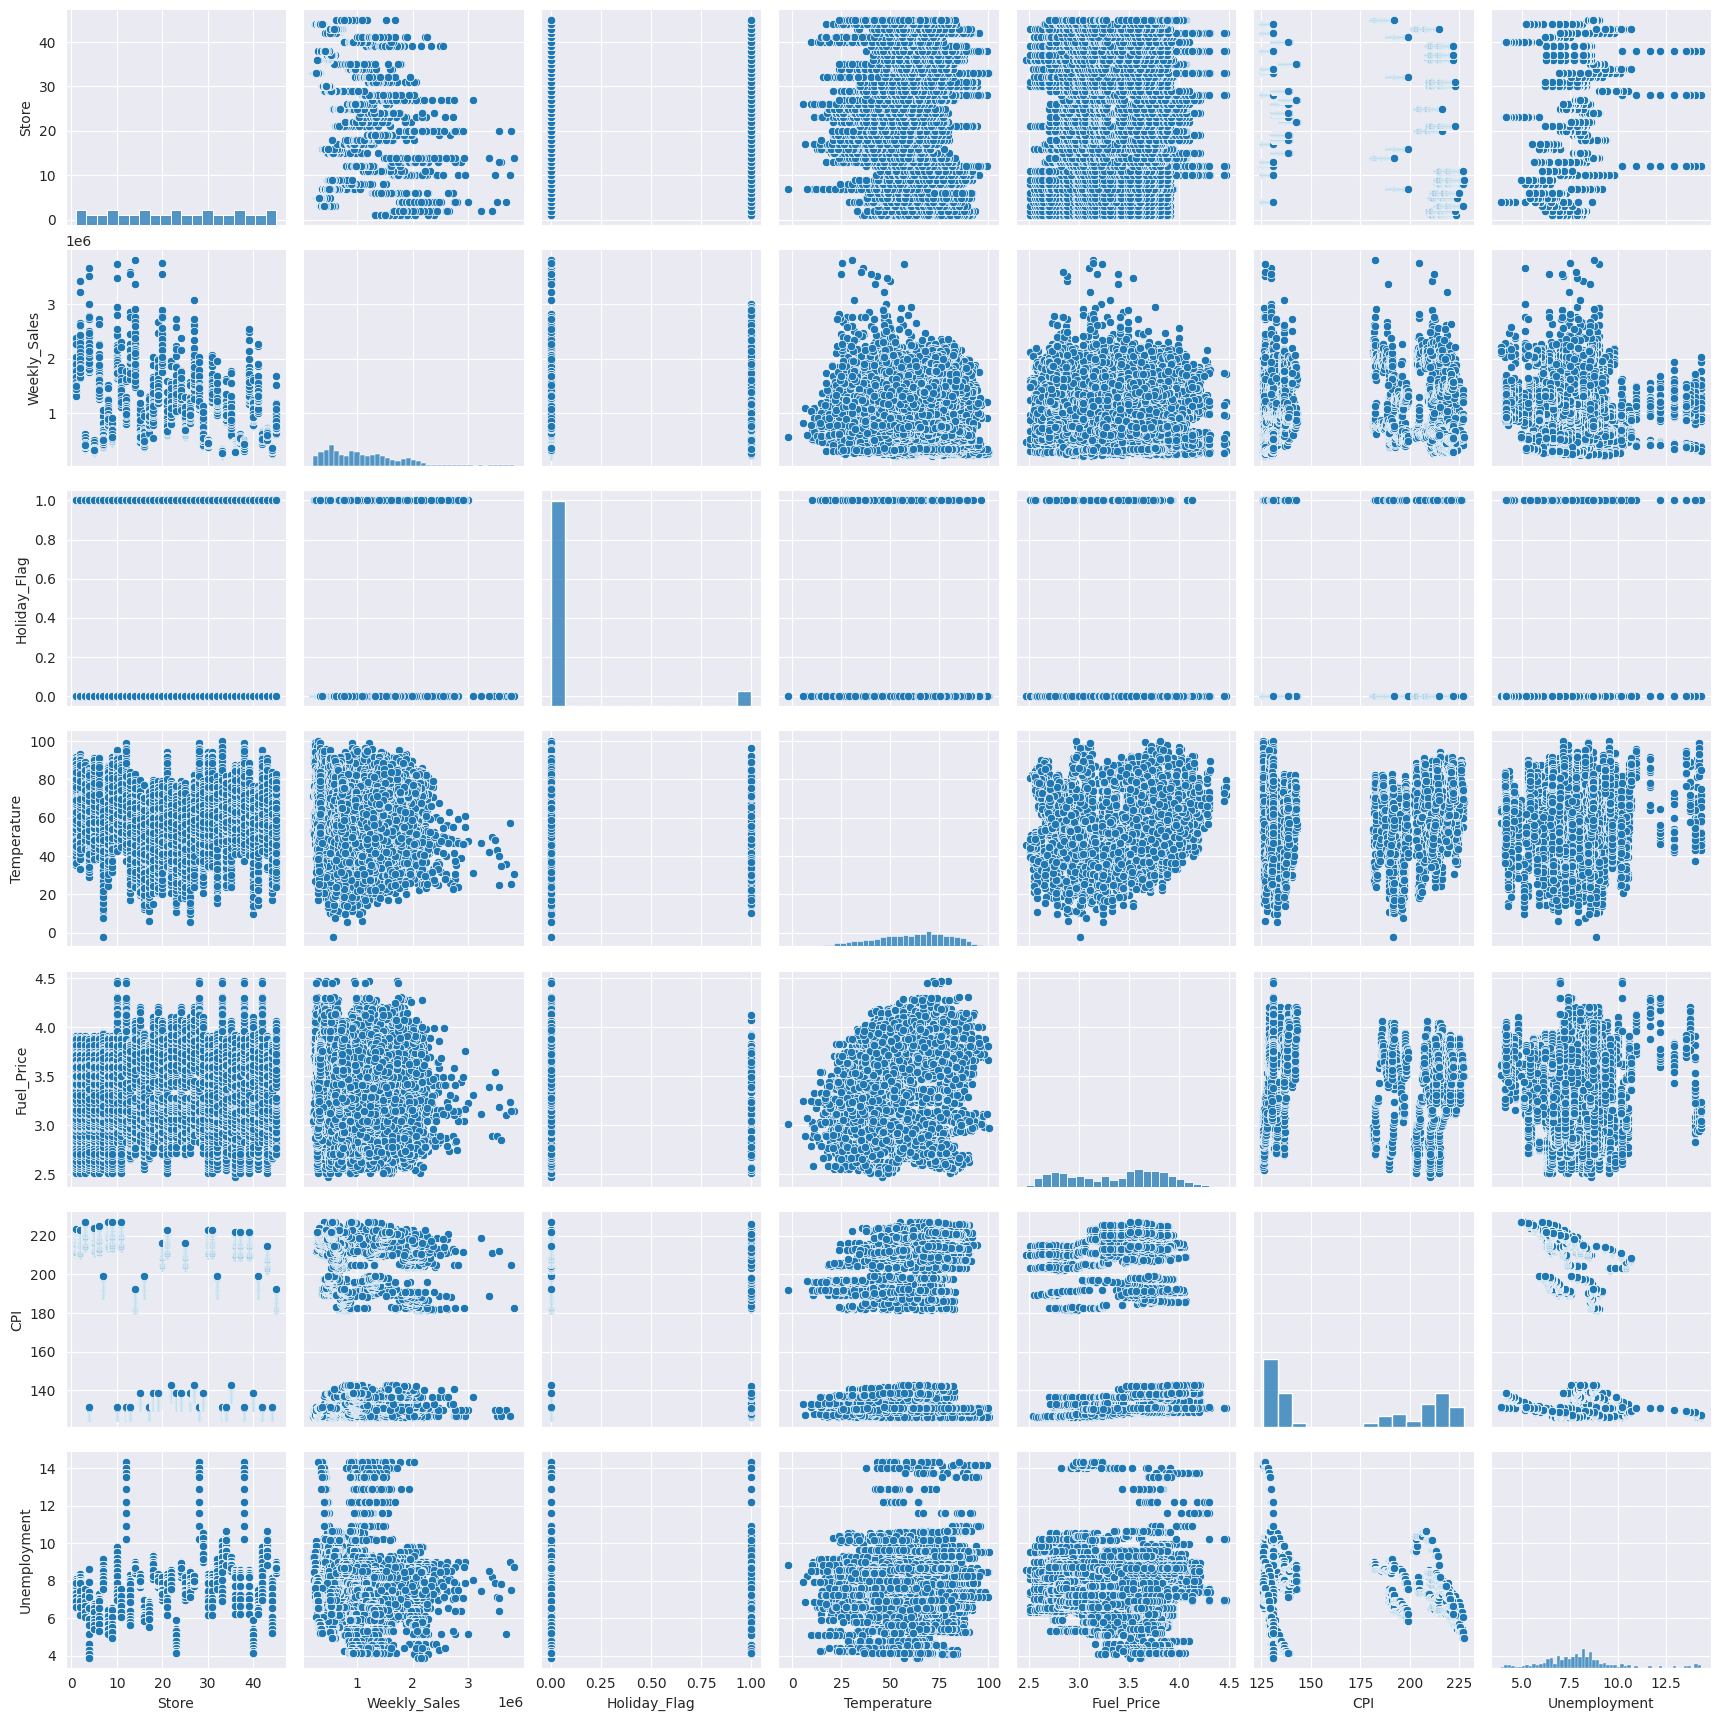

In [116]:
sns.pairplot(dataset)

(<Axes: >,
 count    6.435000e+03
 mean     1.046965e+06
 std      5.643666e+05
 min      2.099862e+05
 25%      5.533501e+05
 50%      9.607460e+05
 75%      1.420159e+06
 max      3.818686e+06
 Name: Weekly_Sales, dtype: float64)

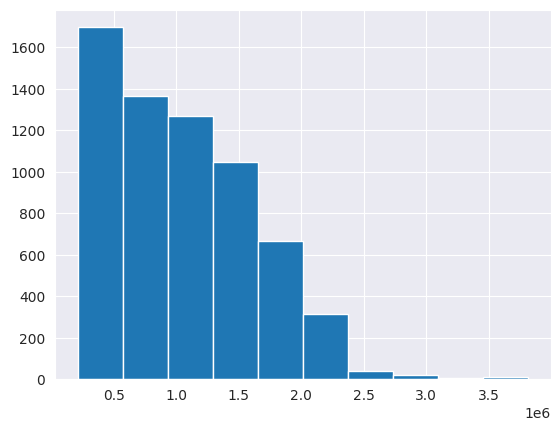

In [117]:
dataset["Weekly_Sales"].hist(), dataset["Weekly_Sales"].describe()

## Preprocesamiento

### Eliminar outliers de Weekly_Sales

(<Axes: >,
 count    6.405000e+03
 mean     1.037191e+06
 std      5.466765e+05
 min      2.099862e+05
 25%      5.517996e+05
 50%      9.579975e+05
 75%      1.415474e+06
 max      2.740057e+06
 Name: Weekly_Sales, dtype: float64)

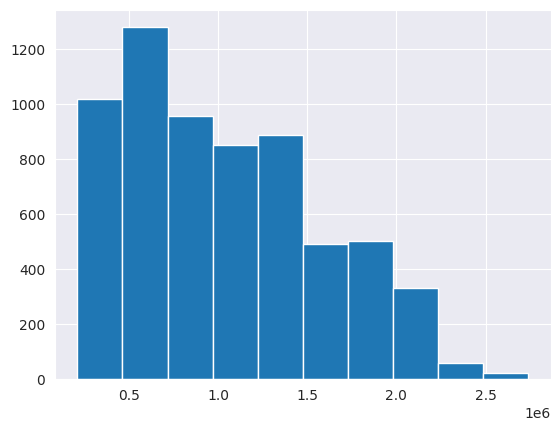

In [118]:
# Eliminar outliers de Weekly_Sales (valores mayores a 3 desviaciones estandar)
dataset = dataset[dataset['Weekly_Sales'] < dataset['Weekly_Sales'].mean() + 3 * dataset['Weekly_Sales'].std()]
dataset["Weekly_Sales"].hist(), dataset["Weekly_Sales"].describe()

### Reemplazar las fechas por un valor numerico (dias desde 1970-01-01)

In [119]:
dataset['Date'] = pd.to_datetime(dataset['Date'], format="%d-%m-%Y")
dataset['Date'] = (dataset['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
dataset['Date'] = dataset['Date'].map(lambda x: int(x))
dataset.dtypes

/tmp/ipykernel_2106981/3105072355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Date'] = pd.to_datetime(dataset['Date'], format="%d-%m-%Y")
/tmp/ipykernel_2106981/3105072355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Date'] = (dataset['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
/tmp/ipykernel_2106981/3105072355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Store             int64
Date              int64
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

### One-hot de columnas categoricas

In [120]:
dataset["class"] = dataset["Store"].astype(str) + "_" + dataset["Holiday_Flag"].astype(str)
dataset = pd.get_dummies(dataset, columns=['Store', 'Holiday_Flag'], dtype=int)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6405 entries, 0 to 6434
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            6405 non-null   int64  
 1   Weekly_Sales    6405 non-null   float64
 2   Temperature     6405 non-null   float64
 3   Fuel_Price      6405 non-null   float64
 4   CPI             6405 non-null   float64
 5   Unemployment    6405 non-null   float64
 6   class           6405 non-null   object 
 7   Store_1         6405 non-null   int64  
 8   Store_2         6405 non-null   int64  
 9   Store_3         6405 non-null   int64  
 10  Store_4         6405 non-null   int64  
 11  Store_5         6405 non-null   int64  
 12  Store_6         6405 non-null   int64  
 13  Store_7         6405 non-null   int64  
 14  Store_8         6405 non-null   int64  
 15  Store_9         6405 non-null   int64  
 16  Store_10        6405 non-null   int64  
 17  Store_11        6405 non-null   int64 

/tmp/ipykernel_2106981/4024587475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["class"] = dataset["Store"].astype(str) + "_" + dataset["Holiday_Flag"].astype(str)


### Normalizar las columnas numericas

<Axes: >

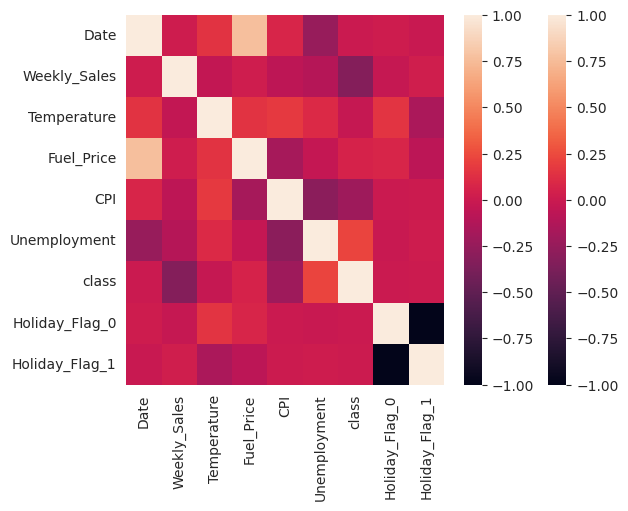

In [121]:
sns.heatmap(dataset.corr())
# Now ignoring columns matching the pattern 'Store_*' and 'Holiday_Flag_*'
sns.heatmap(dataset.loc[:, ~dataset.columns.str.match('Store_*')].corr())

### Separar las columnas de features y target, hacer train-test split

In [122]:
X = dataset.drop(columns=['Weekly_Sales'])
y = dataset['Weekly_Sales']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=111, stratify=dataset["class"])
train_X.drop(columns=['class'], inplace=True)
test_X.drop(columns=['class'], inplace=True)
train_dataset = pd.concat([train_X, train_y], axis=1)
test_dataset = pd.concat([test_X, test_y], axis=1)
len(train_X), len(test_X), len(train_y), len(test_y)

(5124, 1281, 5124, 1281)

In [138]:
pd.DataFrame({"train": train_y, "test": test_y}).describe()

,train,test
count,5.124000e+03,1281.000000
mean,-1.109356e-16,0.016347
std,1.000098e+00,1.017272
min,-1.508655e+00,-1.515176
25%,-8.896082e-01,-0.879993
50%,-1.409158e-01,-0.149010
75%,6.962817e-01,0.699176
max,3.127201e+00,3.129106


### Normalizar las columnas numericas

In [124]:
scaler = StandardScaler()
columns = ['Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
train_dataset[columns] = scaler.fit_transform(train_dataset[columns])
test_dataset[columns] = scaler.transform(test_dataset[columns])
train_X = train_dataset.drop(columns=['Weekly_Sales'])
train_y = train_dataset['Weekly_Sales']
test_X = test_dataset.drop(columns=['Weekly_Sales'])
test_y = test_dataset['Weekly_Sales']

## Funciones de ploteo extra

In [125]:
def plot_prediction_output(plot_X, plot_y, plot_y_h):
    plt.figure()
    
    inv_y = scaler.inverse_transform(plot_X.assign(Weekly_Sales=plot_y)[columns])[columns.index("Weekly_Sales")]
    inv_yh = scaler.inverse_transform(plot_X.assign(Weekly_Sales=plot_y_h)[columns])[columns.index("Weekly_Sales")]

    # point size = 5, transparency = 0.5
    plt.plot(inv_y, inv_yh, 'o', markersize=5, alpha=0.5)
    # Add line
    x = np.linspace(inv_y.min(), inv_y.max(), 100)
    plt.plot(x, x, 'r')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('True vs Predicted (Weekly Sales)')
    # # Log x and y
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    # 
    # 
    plt.figure()
    # point size = 5, transparency = 0.5
    plt.plot(plot_y, plot_y_h, 'o', markersize=2, alpha=0.5)
    # Add line
    x = np.linspace(plot_y.min(), plot_y.max(), 100)
    plt.plot(x, x, 'r')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('True vs Predicted (Weekly Sales std-norm scaled)')
    # Log x and y
    # plt.tight_layout()
    plt.show()

    # Compute r2 and nmse
    print("R2", r2_score(plot_y, plot_y_h))
    print("NMSE", -mean_squared_error(plot_y, plot_y_h))


## Entrenar un modelo base de regresion lineal

La idea aca es hacer un CV de 10 folds y ver N-MSE y R2

In [126]:
kf = KFold(n_splits=10, shuffle=True, random_state=111)
model = LinearRegression()
r2 = cross_val_score(model, train_X, train_y, cv=kf, scoring='r2')
nmse = cross_val_score(model, train_X, train_y, cv=kf, scoring='neg_mean_squared_error')
print("R2", r2.mean())
print("NMSE", nmse.mean())

R2 0.9351580002805442
NMSE -0.06467316617138562


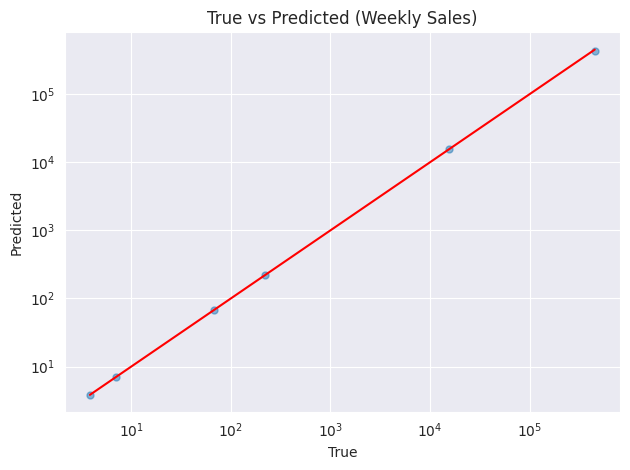

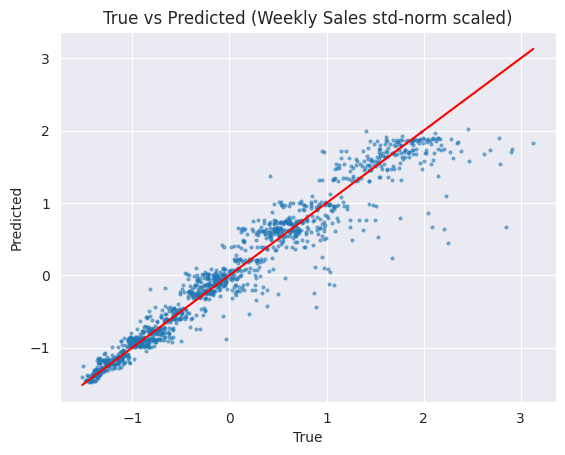

R2 0.933746522269396
NMSE -0.06850838559804347


In [127]:
model.fit(train_X, train_y)
linear_model = model
plot_prediction_output(test_X, test_y, model.predict(test_X))

## Entrenar un modelo de regresion Ridge

Denuevo usamos un CV de 10 folds y vemos N-MSE y R2
Pero hacemos una busqueda de hiperparametros para el alpha

Best alpha 0.08286427728546843
Best NMSE -0.06466460092634087


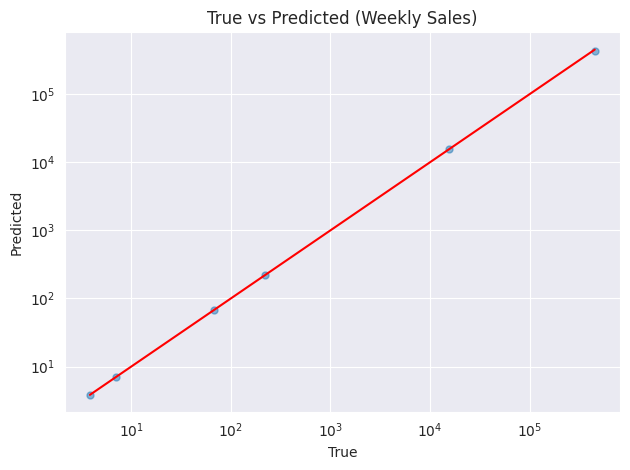

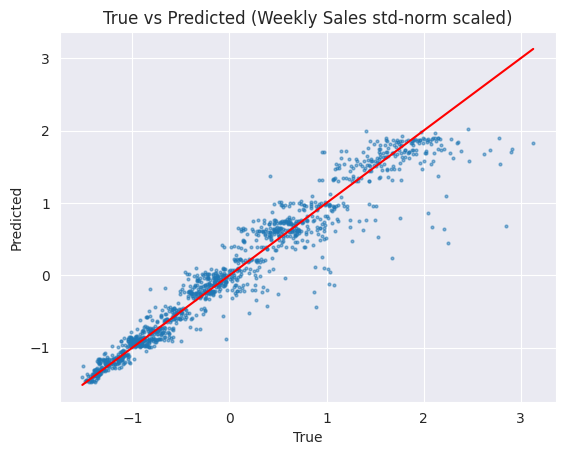

R2 0.9337005977195211
NMSE -0.06855587316970041


In [128]:
alphas = np.logspace(-2, 7, 50)
param_grid = {'alpha': alphas}
kf = KFold(n_splits=10, shuffle=True, random_state=111)
grid = GridSearchCV(Ridge(random_state=111, max_iter=1000, tol=0.001), param_grid, cv=kf, scoring='neg_mean_squared_error')
grid.fit(train_X, train_y)
best_alpha = grid.best_params_['alpha']
print("Best alpha", best_alpha)
print("Best NMSE", grid.best_score_)
ridge_model = grid
plot_prediction_output(test_X, test_y, grid.predict(test_X))


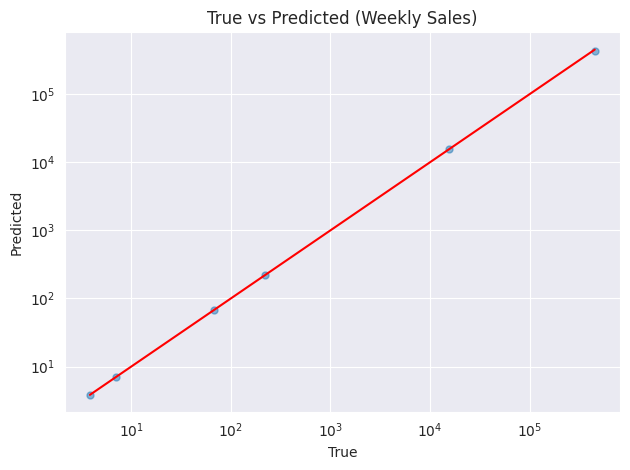

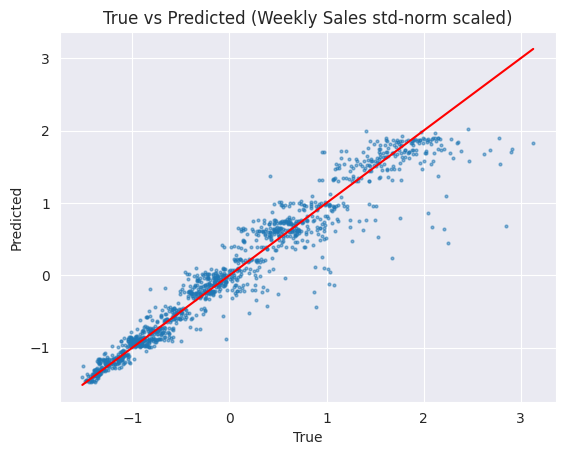

R2 0.9337005977195211
NMSE -0.06855587316970041


In [129]:
model = Ridge(alpha=best_alpha, random_state=111, max_iter=1000, tol=0.001)
model.fit(train_X, train_y)
plot_prediction_output(test_X, test_y, model.predict(test_X))

<Axes: xlabel='param_alpha'>

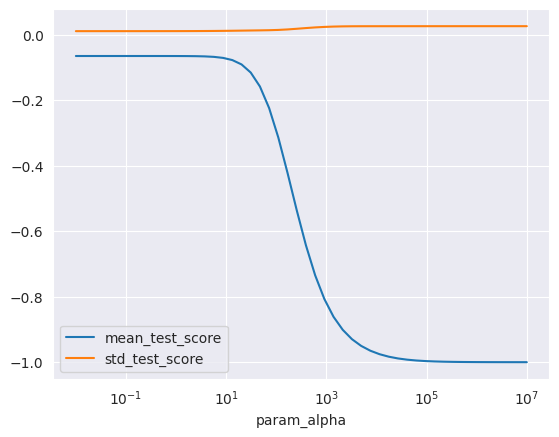

In [130]:
pd.DataFrame(grid.cv_results_)[['param_alpha', 'mean_test_score', 'std_test_score']].set_index("param_alpha").plot(logx=True)

## Entrenar un modelo de regression Lasso

La idea es hacer lo mismo que con Ridge, pero con Lasso (10 folds, busqueda de hiperparametros)

/home/federico/anaconda3/envs/main2/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+02, tolerance: 4.597e+00
  model = cd_fast.enet_coordinate_descent(
/home/federico/anaconda3/envs/main2/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.495e+02, tolerance: 4.596e+00
  model = cd_fast.enet_coordinate_descent(
/home/federico/anaconda3/envs/main2/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Best alpha 3.2374575428176467e-06
Best NMSE -0.06466884710439838


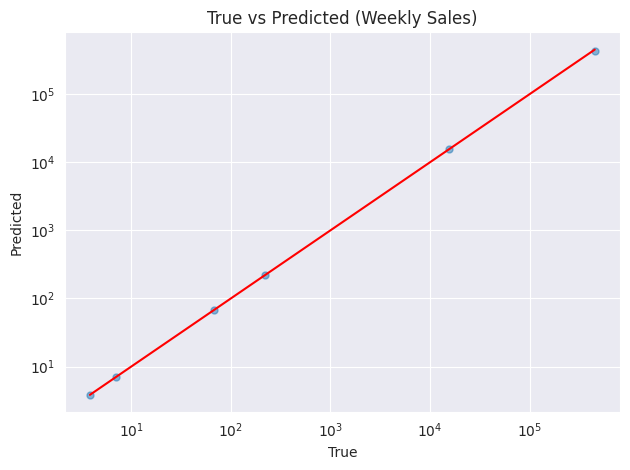

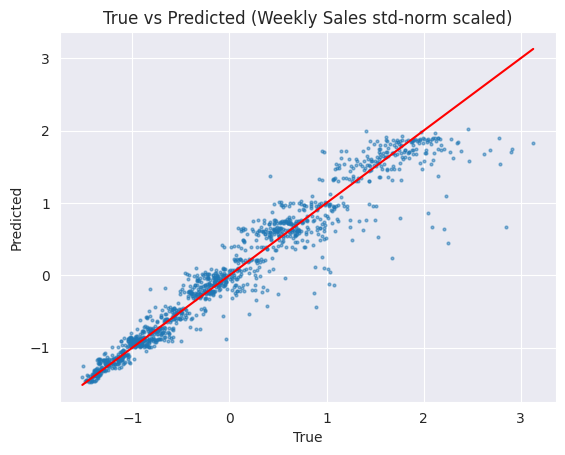

R2 0.9337296257678737
NMSE -0.06852585716453634


In [140]:
alphas = np.logspace(-10, 7, 50)
param_grid = {'alpha': alphas}
kf = KFold(n_splits=10, shuffle=True, random_state=111)
grid = GridSearchCV(Lasso(random_state=111, max_iter=2000, tol=0.001), param_grid, cv=kf, scoring='neg_mean_squared_error')
grid.fit(train_X, train_y)
best_alpha = grid.best_params_['alpha']
print("Best alpha", best_alpha)
print("Best NMSE", grid.best_score_)
lasso_model = grid
plot_prediction_output(test_X, test_y, grid.predict(test_X))

/home/federico/anaconda3/envs/main2/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e+02, tolerance: 5.124e+00
  model = cd_fast.enet_coordinate_descent(


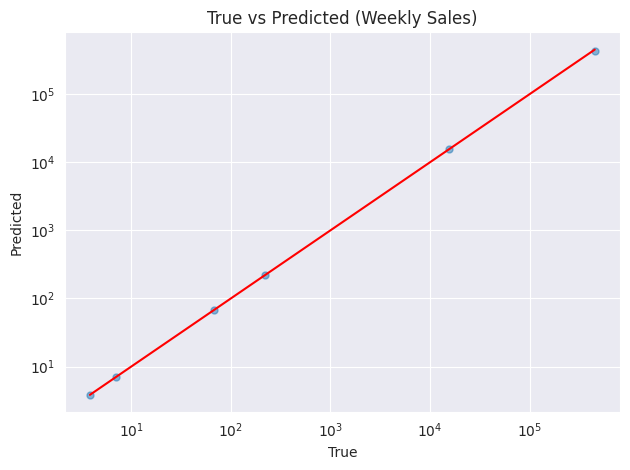

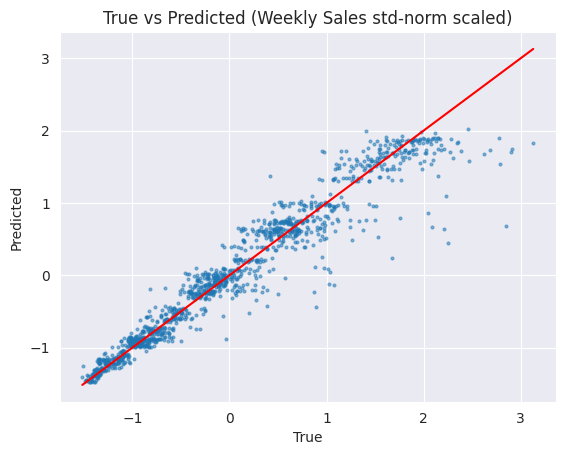

R2 0.9337221451011589
NMSE -0.06853359243244045


In [141]:
model = Lasso(alpha=best_alpha, random_state=111, max_iter=1000, tol=0.001)
model.fit(train_X, train_y)
plot_prediction_output(test_X, test_y, model.predict(test_X))


<Axes: xlabel='param_alpha'>

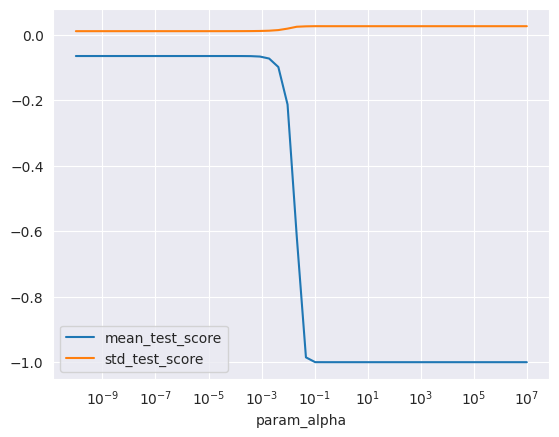

In [142]:
pd.DataFrame(grid.cv_results_)[['param_alpha', 'mean_test_score', 'std_test_score']].set_index("param_alpha").plot(logx=True)

## Entrenar ElasticNet
El modelo ElasticNet es una combinacion de Lasso y Ridge, con dos hiperparametros: alpha y l1_ratio



/home/federico/anaconda3/envs/main2/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e+02, tolerance: 4.597e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/federico/anaconda3/envs/main2/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e+02, tolerance: 4.614e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one

Best alpha 0.0001
Best l1_ratio 0.25
Best NMSE -0.06467854940912801


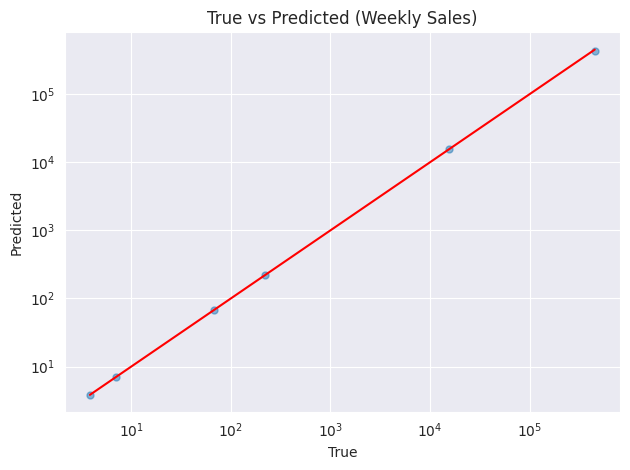

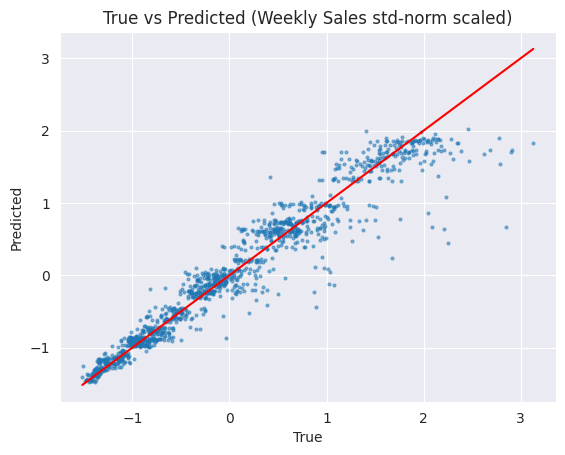

R2 0.9335739092153479
NMSE -0.06868687346118736


In [134]:
alphas = np.logspace(-4, 7, 25)
l1_ratios = np.linspace(0, 1, 25)
param_grid = {'alpha': alphas, 'l1_ratio': l1_ratios}
kf = KFold(n_splits=10, shuffle=True, random_state=111)
grid = GridSearchCV(ElasticNet(random_state=111, max_iter=2000, tol=0.001), param_grid, n_jobs=32, cv=kf, scoring='neg_mean_squared_error')
grid.fit(train_X, train_y)
best_alpha = grid.best_params_['alpha']
best_l1_ratio = grid.best_params_['l1_ratio']
print("Best alpha", best_alpha)
print("Best l1_ratio", best_l1_ratio)
print("Best NMSE", grid.best_score_)
plot_prediction_output(test_X, test_y, grid.predict(test_X))

In [135]:
elastic_model = grid

## Analisis de resultados

Aca tomamos como `(+)` estadisticas que se buscan maximizar y como `(-)` estadisticas que se buscan minimizar.

In [136]:
for model_name, model in {
    "linear_model": linear_model,
    "ridge_model": ridge_model,
    "lasso_model": lasso_model,
    "elastic_model": elastic_model
}.items():
    test_yhat = model.predict(test_X)
    print("===", "Model:", model_name, "===")
    if "best_params_" in dir(model):
        print("Best params:", model.best_params_)
    print("(+) R2", r2_score(test_y, test_yhat))
    print("(+) NMSE", -mean_squared_error(test_y, test_yhat))
    print("(-) RMSE", root_mean_squared_error(test_y, test_yhat))

=== Model: linear_model ===
(+) R2 0.933746522269396
(+) NMSE -0.06850838559804347
(-) RMSE 0.26174106593739443
=== Model: ridge_model ===
Best params: {'alpha': np.float64(0.08286427728546843)}
(+) R2 0.9337005977195211
(+) NMSE -0.06855587316970041
(-) RMSE 0.26183176501276617
=== Model: lasso_model ===
Best params: {'alpha': np.float64(0.0001)}
(+) R2 0.9336121227377835
(+) NMSE -0.06864735935838479
(-) RMSE 0.26200641091084925
=== Model: elastic_model ===
Best params: {'alpha': np.float64(0.0001), 'l1_ratio': np.float64(0.25)}
(+) R2 0.9335739092153479
(+) NMSE -0.06868687346118736
(-) RMSE 0.26208180681075016


Al parecer, el mejor modelo es el lineal, porque cualquier desviacion en alpha de 0, empeora la prediccion.

Esto se debe a que en la grid search, alpha=0 no estaba permitido

In [156]:
pd.DataFrame({"column": train_X.columns, "linear": linear_model.coef_, "ridge": ridge_model.best_estimator_.coef_, "lasso": lasso_model.best_estimator_.coef_, "elastic": elastic_model.best_estimator_.coef_})

,column,linear,ridge,lasso,elastic
0,Date,1.572383e-02,0.021622,0.019584,0.026601
1,Temperature,-1.408888e-02,-0.014224,-0.014157,-0.014310
2,Fuel_Price,-3.411781e-02,-0.034015,-0.034104,-0.033470
3,CPI,8.120842e-02,0.005617,0.034757,-0.067504
4,Unemployment,-6.544067e-02,-0.064818,-0.064251,-0.065491
5,Store_1,-1.736010e+10,0.933423,1.058498,1.069188
6,Store_2,-1.736010e+10,1.545673,1.671358,1.679383
7,Store_3,-1.736010e+10,-1.204358,-1.083092,-1.054192
8,Store_4,-1.736010e+10,1.771048,1.961814,1.742395
9,Store_5,-1.736010e+10,-1.387199,-1.263739,-1.242062


Parece que le asigna muchisimo peso negativo a los store y si es vacaciones o no - lo cual tiene sentido, porque si es vacaciones, la gente compra mas.

Pero es medio raro y supongo que es porque al ser one-hot no esta "normalizado" con el scaler.

Por ahi normalizando con el scaler el output del one-hot, se podria ver mejor.

In [163]:
linear_model.coef_[-2:][0] - linear_model.coef_[-2:][1]

np.float64(-0.1085205078125)